# DPS distributions from convolutions

Show how a DPS distribution can be computed by convolving the 1-hist damage distribution n hit times

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from counting import Count
from moments import Rotation

import sys
sys.path.append('../')
from variance import *

## Simulation functions

Converts a set of hit types to a damage amount after a random $\pm 5\%$ damage roll.

In [7]:
def hits2pot(x, l_c, l_d, d2, buffs=None):
    """
    Convert a vector of non-DoT hit types to damage

    Inputs:
    x: 4 x n_trials list/numpy array, vector containing number of each hit type, [normal hits, crit hits, direct hits, crit-direct hits].
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    d2: float, base D2 damage value
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    Returns:
    damage dealt, vector with n_trials elements 
    """

    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)

    n_trials = x[:,0].size
    potency = np.zeros(n_trials)

    a_n, b_n = get_nh_bounds(d2)
    a_c, b_c = get_ch_bounds(d2, l_c)
    a_d, b_d = get_dh_bounds(d2, l_d)
    a_cd, b_cd = get_cdh_bounds(d2, l_c, l_d)

    # This is a prime example of how for loops are slow
    # using numpy broadcasting would be much faster, but would take some more effort.
    for a in range(n_trials):
        nh_dmg  = np.floor(np.random.randint(a_n,  b_n,  size=(x[a,0])) * buff_prod)
        ch_dmg  = np.floor(np.random.randint(a_c,  b_c,  size=(x[a,1])) * buff_prod)
        dh_dmg  = np.floor(np.random.randint(a_d,  b_d,  size=(x[a,2])) * buff_prod)
        cdh_dmg = np.floor(np.random.randint(a_cd, b_cd, size=(x[a,3])) * buff_prod)
        
        potency[a] = np.sum(nh_dmg) + np.sum(ch_dmg) + np.sum(dh_dmg) + np.sum(cdh_dmg)

    return potency

def dots2pot(x, l_c, l_d, d2, buffs=None):
    """
    Convert a vector of DoT hit types to damage

    Inputs:
    x: 4 x n_trials list/numpy array, vector containing number of each hit type, [normal hits, crit hits, direct hits, crit-direct hits].
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    d2: float, base D2 damage value
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    Returns:
    damage dealt, vector with n_trials elements 
    """

    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)
    
    n_trials = x[:,0].size
    potency = np.zeros(n_trials)
    a_n, b_n = get_nh_bounds(d2)

    for a in range(n_trials):
        nh_dmg  = np.floor(np.random.randint(a_n, b_n, size=(x[a,0])) * buff_prod)
        ch_dmg  = np.floor(np.floor(np.floor(np.random.randint(a_n, b_n, size=(x[a,1])) * l_c) / 1000) * buff_prod)
        dh_dmg  = np.floor(np.floor(np.floor(np.random.randint(a_n, b_n, size=(x[a,2])) * l_d) / 100) * buff_prod)

        cdh1 = np.floor(np.floor(np.random.randint(a_n, b_n, size=(x[a,3])) * l_c) / 1000)
        cdh_dmg = np.floor(np.floor(np.floor(cdh1 * l_d) / 100) * buff_prod)
        
        potency[a] = np.sum(nh_dmg) + np.sum(ch_dmg) + np.sum(dh_dmg) + np.sum(cdh_dmg)    

    return potency

## Example PMFs for a single skill landing different numbers of hits

Simulated, convolved, and parameterizing a skew-normal

In [8]:
a = Count(2500, 3000)

rotation = pd.DataFrame({
    'd2': [5000],
    'n': [25],
    'p': [a.p],
    'l_c': [a.l_c],
    'buffs': [[1.1]],
    'is-dot': [0],
    'skill-name': ['test']})

drotation = pd.DataFrame({
    'd2': [5000],
    'n': [15],
    'p': [a.p],
    'l_c': [a.l_c],
    'buffs': [[1.1]],
    'is-dot': [1]})

n = [2, 5, 10, 15]

In [9]:
x_vals = [np.random.multinomial(c, a.p, 250000) for c in n]
dmg_dist = [hits2pot(c, a.l_c, 125, rotation['d2'][0], rotation['buffs'][0]) for c in x_vals]

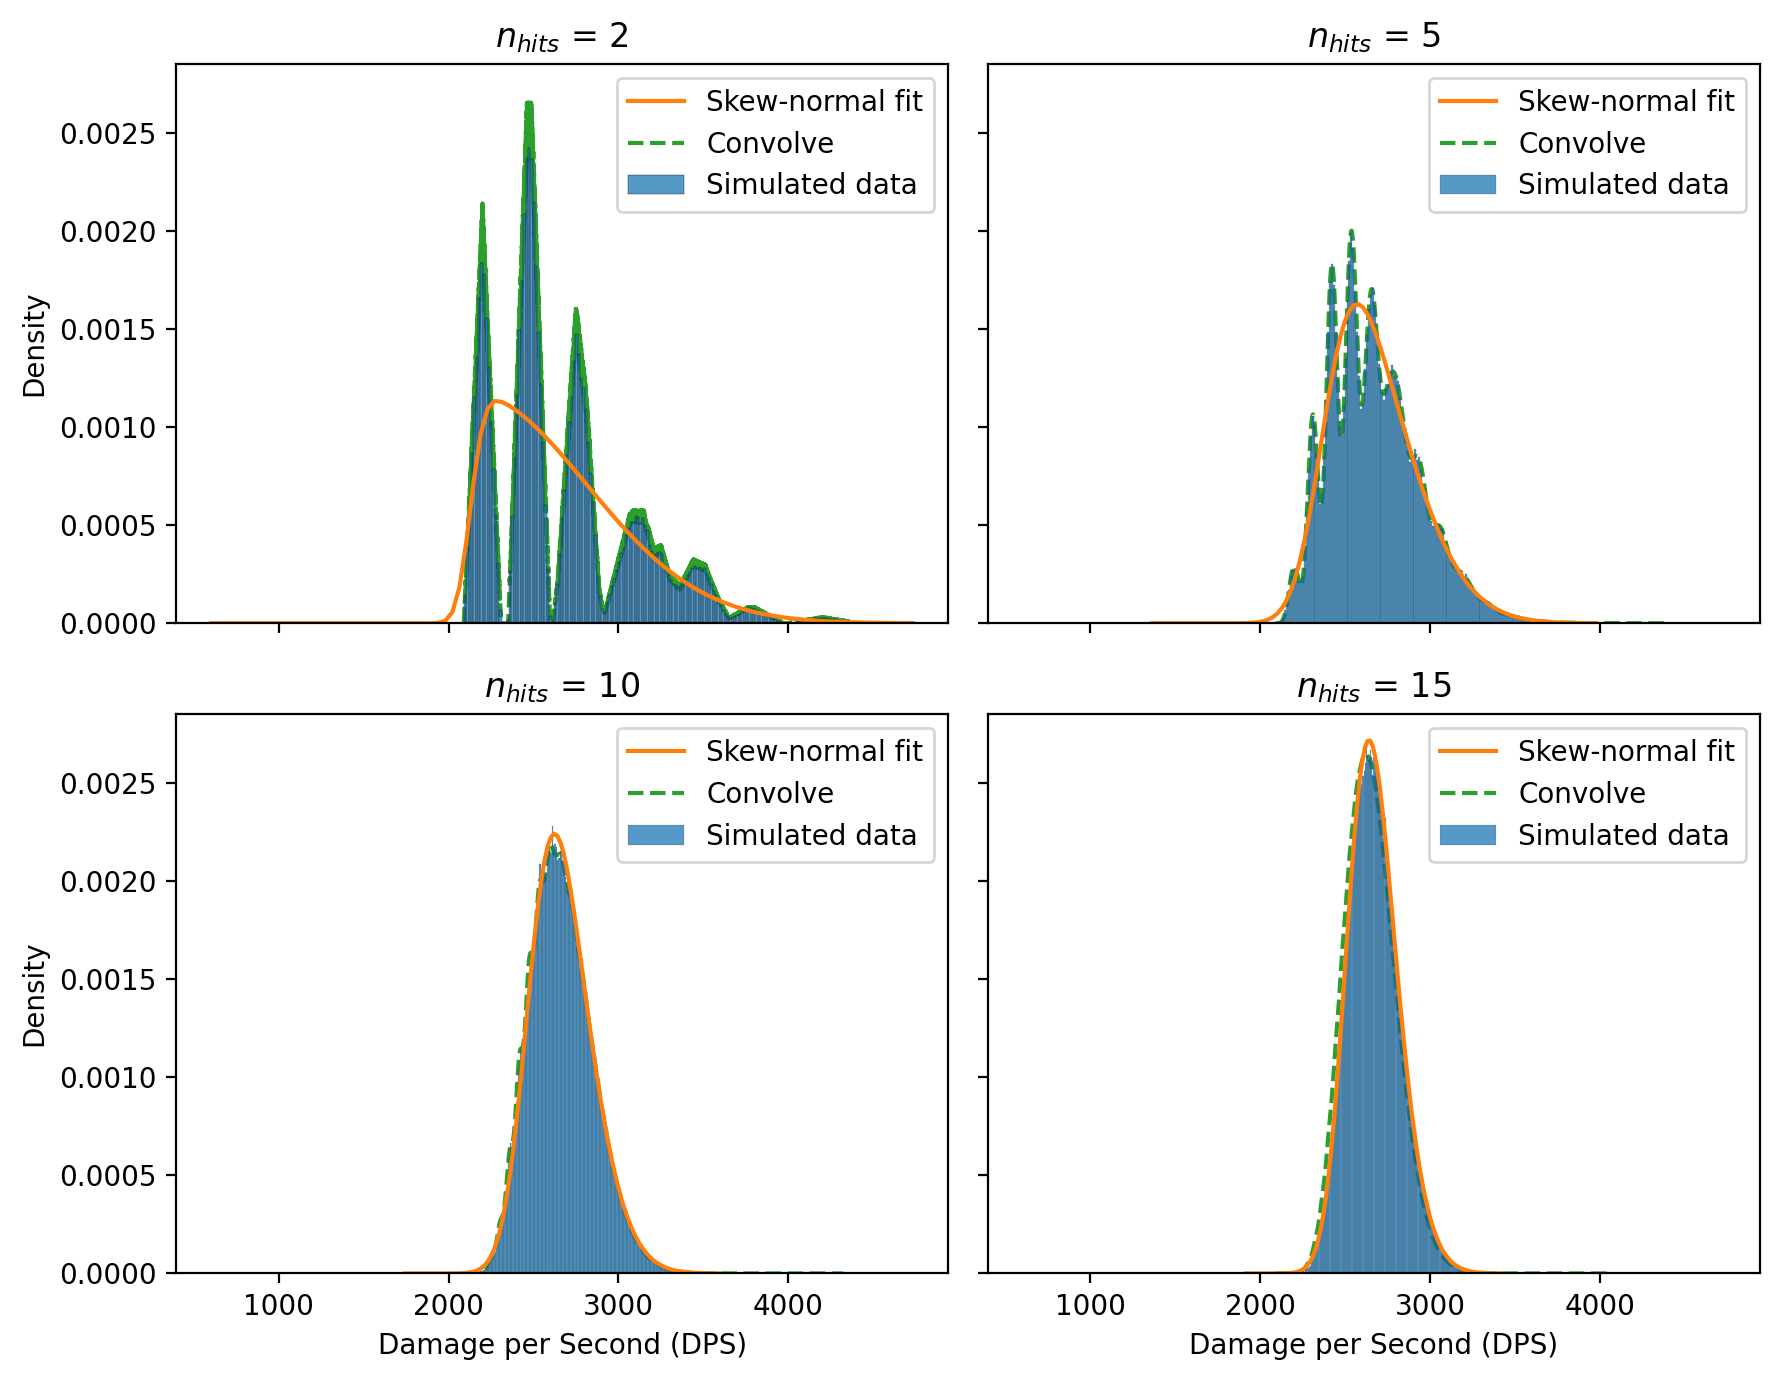

In [10]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(9,7), dpi=200)

for a in range(len(n)):
    t = n[a] * 2.5
    rotation['n'].update(n[a])

    ax_idx = np.unravel_index(a, (2,2))
    sns.histplot(dmg_dist[a]/t, ax=ax[ax_idx], stat='density', label='Simulated data')
    r = Rotation(rotation, t)
    r.plot_rotation_distribution(ax[ax_idx], c='C1', label='Skew-normal fit')
    x, y = r.convolve_pmf(0)
    ax[ax_idx].plot(x, y, label='Convolve', c='C2', zorder=0, linestyle='--')
    ax[ax_idx].legend()
    ax[ax_idx].set_title(r'$n_{hits}$ '+'= {}'.format(n[a]))
fig.tight_layout()

## Performance comparison between PMFs from moments vs. convolutions

This cell calculates the first three moments of the DPS distribution using moment generating functions
Moments: Can parameterize a skew normal using the first three moments

In [11]:
%%timeit -n 10
Rotation(rotation, 2.5*rotation['n'][0])

2.05 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Convolutions: the PMF for sums of random variables can be computed by convolving PMFs

But this is slow (even with efficient FFT). Scaling becomes even worse with larger n

In [12]:
r = Rotation(rotation, 2.5*rotation['n'][0])

In [13]:
%%timeit -n 5
r.convolve_pmf(0)

57.2 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Example rotation

Using somewhat reasonable values for a WHM as of 5.5

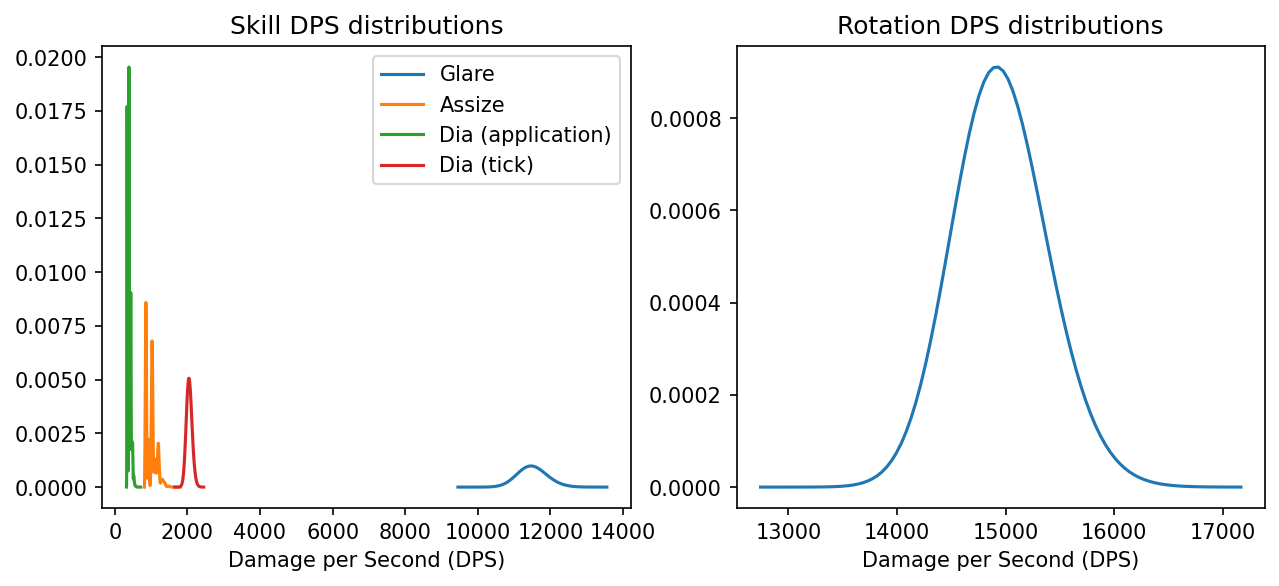

In [14]:
a = Count(3623, 900)
t = 112
rotation = pd.DataFrame({
    'd2': [25000, 32000, 9500, 5300],
    'n': [44, 3, 4, t//3],
    'p': [a.p]*4,
    'l_c': [a.l_c]*4,
    'buffs': [1]*4,
    'is-dot': [0, 0, 0, 1],
    'skill-name': ['Glare', 'Assize', 'Dia (application)', 'Dia (tick)']})

r = Rotation(rotation, t)
fig, ax = plt.subplots(1, 2, figsize=(10,4), dpi=150)

r.plot_skill_distributions(ax[0])
r.plot_rotation_distribution(ax[1])

ax[0].set_title('Skill DPS distributions')
ax[0].legend()

ax[1].set_title('Rotation DPS distributions')

plt.show()